# Image Classification

In this task, binary classification on images will be performed. First, a baseline based on PCA algorithm and Logistic Regression will be introduced. Then, a Convolutional Neural Network will be trained to improve classification quality.

I used several sources of knowledge. For the PCA part, MIPT&Coursera ["Unsupervised learning" course](https://www.coursera.org/learn/unsupervised-learning/home/welcome), and for the CNN part, Google&Udacity ["Deep Learning" course](https://www.udacity.com/course/deep-learning--ud730) and general architecture like proposed in [ImageNet Classification With Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import os
import pickle
from scipy import ndimage
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

sns.set_style('whitegrid')
sns.despine()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load data

Data is RGB images of size $32 \times 32$. The `ndimage` module does all the work for reading images into 3-dimensional arrays, which are then organized into one 4-dimensional collection. Finally, train/validation/test split is performed.

I keep images RGB to make use of as much information as possible. Since the data size is small, it doesn't affect performance very much.

In [2]:
image_size = 32
pixel_depth = 255.
num_channels = 3

def load_class(name):
    """
    Loads one class into memory.
    
    Args:
        name (string): Class name.

    Returns:
        images: Tensor of shape (num_images, image_size, image_size).
    """
    assert name in ['clocks', 'crocodiles'], 'Class name %s not recognized' % name
    image_files = os.listdir('./data/%s/' % name)
    images = np.ndarray(shape=(len(image_files), image_size, image_size, num_channels), dtype=np.float32)
    num_images = 0
        
    for image in image_files:
        path = os.path.join('./data/%s/' % name, image)
        try:
            image_data = (ndimage.imread(path).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size, num_channels):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            images[num_images, :, :, :] = image_data
            num_images += 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, 'skipping.')
    
    images = images[0:num_images, :, :, :]
    print('Class %s tensor:' % name, images.shape)
    return images

def load_classes(force=False):
    """
    Pickles classes.
    
    Args:
        force (bool): True if rewrite existing pickles, False otherwise.
        
    Returns:
        names (list of strings): Class names.
    """
    names = ['clocks', 'crocodiles']
    for name in names:
        if os.path.exists('./data/%s.pickle' % name) and not force:
            print('%s.pickle already present, skipping.' % name)
        else:
            print 'Pickling %s.pickle' % name
            images = load_class(name)
            try:
                with open('./data/%s.pickle' % name, 'w') as fout:
                    pickle.dump(images, fout, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', '%s.pickle' % name, ':', e)
    return names

def make_arrays(rows, cols, depth):
    """
    Allocates memory for a tensor of specified length.
    
    Args:
        rows (int): First dimension.
        cols (int): Second and third dimension.
        depth (int): Fourth dimension.

    Returns:
        dataset (list): Tensor of shape (rows, image_size, image_size).
        labels (list): Tensor of shape (rows).
    """
    if rows:
        dataset = np.ndarray((rows, cols, cols, depth), dtype=np.float32)
        labels = np.ndarray(rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_classes(names, train_size, valid_size=0, test_size=0):
    """
    Merges classes into one dataset, performs train/validation split.
    
    Args:
        names (list of strings): Class names.
        train_size (int): Amount of data to keep for training.
        valid_size (int): Amount of data to keep for validation.
        valid_size (int): Amount of data to keep for test.

    Returns:
        valid_dataset (list): Tensor of shape (valid_size, image_size, image_size, num_channels).
        valid_labels (list): Tensor of shape (valid_size).
        train_dataset (list): Tensor of shape (train_size, image_size, image_size, num_channels).
        train_labels (list): Tensor of shape (train_size).
        test_dataset (list): Tensor of shape (test_size, image_size, image_size, num_channels).
        test_labels (list): Tensor of shape (test_size).
    """
    num_classes = len(names)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size, num_channels)
    train_dataset, train_labels = make_arrays(train_size, image_size, num_channels)
    test_dataset, test_labels = make_arrays(test_size, image_size, num_channels)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    ttsize_per_class = test_size // num_classes
    
    start_v, start_t, start_tt = 0, 0, 0
    end_v, end_t, end_tt = vsize_per_class, tsize_per_class, ttsize_per_class
    end_l = vsize_per_class + tsize_per_class + ttsize_per_class
    for label, src in enumerate(names):
        try:
            with open('./data/%s.pickle' % src, 'r') as fin:
                images = pickle.load(fin)
                np.random.shuffle(images)
                if valid_dataset is not None:
                    valid_images = images[:vsize_per_class, :, :, :]
                    valid_dataset[start_v:end_v, :, :, :] = valid_images
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                if test_dataset is not None:
                    test_images = images[vsize_per_class:vsize_per_class+ttsize_per_class, :, :, :]
                    test_dataset[start_tt:end_tt, :, :, :] = test_images
                    test_labels[start_tt:end_tt] = label
                    start_tt += ttsize_per_class
                    end_tt += ttsize_per_class
                    
                train_images = images[vsize_per_class+ttsize_per_class:end_l, :, :, :]
                train_dataset[start_t:end_t, :, :, :] = train_images
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', src, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels

def shuffle(dataset, labels):
    """
    Shuffles dataset w.r.t. labels.
    
    Args:
        dataset (list): 3D-Tensor to shuffle.
        labels (list): 1D-Tensor to shuffle.

    Returns:
        shuffled_dataset (list): Shuffled Tensor `dataset`.
        shuffled_labels (list): Shuffled Tensor `labels`.
    """
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

def load_data(filename, save=None):
    """
    Saves/loads all necessary data for clocks&crocs task.
    
    Args:
        filename (string, optional): Filename to save/load.
        save (dict, optional): Dictionary to save.
        
    Returns:
        save (dict): Data dictionaty.
    """
    pickle_file = './data/%s' % filename
    if not os.path.exists(pickle_file):
        try:
            with open(pickle_file, 'w') as fout:
                pickle.dump(save, fout, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise
    else:
        with open(pickle_file, 'r') as fin:
            save = pickle.load(fin)
    return save
            
def one_hot(labels, depth=2):
    """
    One-hot `labels` into vector of given `depth`.
    
    Args:
        labels (list): Values to one-hot.
        depth (int): Depth of resulting vector.
        
    Return:
        One-hot representation of `labels`.
    """
    labels = (np.arange(depth) == labels[:,None]).astype(np.float32)
    return labels

In [3]:
total_size = 1000
test_size = int(0.1 * total_size)
valid_size = int(0.1 * total_size)
train_size = total_size - valid_size - test_size

names = load_classes()
valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels = merge_classes(names,
                                                                                                    train_size,
                                                                                                    valid_size,
                                                                                                    test_size)

# valid_dataset, valid_labels = shuffle(valid_dataset, valid_labels)
# train_dataset, train_labels = shuffle(train_dataset, train_labels)
# test_dataset, test_labels = shuffle(test_dataset, test_labels)

# save = {'train_dataset': train_dataset, 'train_labels': train_labels, 
#         'valid_dataset': valid_dataset, 'valid_labels': valid_labels, 
#         'test_dataset': test_dataset, 'test_labels': test_labels}
# save = load_data('data.pickle', save=save)

save = load_data('data.pickle')
train_dataset = save['train_dataset']
train_labels = save['train_labels']
valid_dataset = save['valid_dataset']
valid_labels = save['valid_labels']
test_dataset = save['test_dataset']
test_labels = save['test_labels']
del save

train_labels = one_hot(train_labels)
valid_labels = one_hot(valid_labels)
test_labels = one_hot(test_labels)

train_pca_feed = np.concatenate([train_dataset, valid_dataset]).reshape((train_dataset.shape[0]
                                                                         + valid_dataset.shape[0], -1))
y_train = [0 if l[0] == 1 else 1 for l in np.concatenate([train_labels, valid_labels])]
test_pca_feed = test_dataset.reshape((test_dataset.shape[0], -1))
y_test = [0 if l[0] == 1 else 1 for l in test_labels]

clocks.pickle already present, skipping.
crocodiles.pickle already present, skipping.


## PCA and Logistic Regression

Principal Component Analysis is a powerful technique for dimension reduction. It projects high-dimensional data into smaller-dimensional space losing the least possible variance in data. PCA objective can be most easily obtained with SVD decomposition, then eigenvalue descending sorting and finally cutting projection matrices by specified number of components. Here, though, I use `sklearn` implementation, as it is a baseline.

To calculate the optimal number of components, PCA-specific log likelyhood is used. To calculate classification quality, accuracy metric is used.

In [4]:
if not os.path.exists('./model/gs.pickle'):
    params = {'n_components': np.arange(1, 501, 2)}
    estimator = PCA()
    gs = GridSearchCV(estimator, params)
    gs.fit(train_pca_feed)
    with open('./model/gs.pickle', 'w') as fout:
        pickle.dump(gs, fout)
else:
    with open('./model/gs.pickle', 'r') as fin:
        gs = pickle.load(fin)

In [5]:
scores = [x[1] for x in gs.grid_scores_]
n_components = gs.best_params_['n_components']

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.]),
 <a list of 6 Text yticklabel objects>)

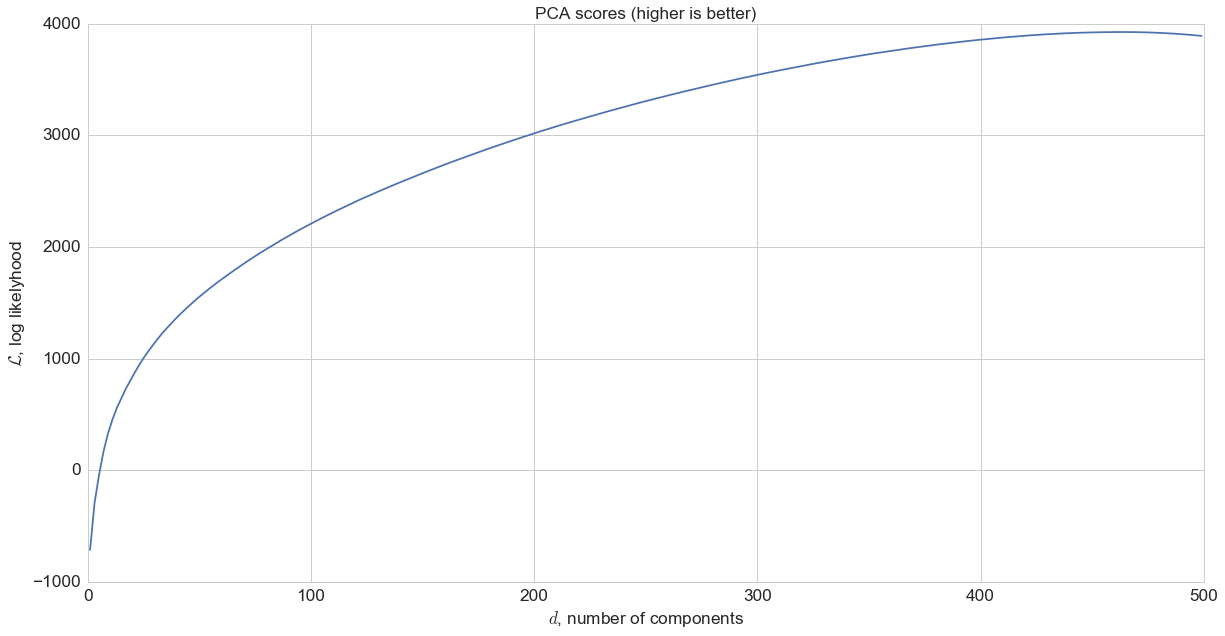

In [6]:
plt.figure(figsize=(20, 10))
plt.title('PCA scores (higher is better)', fontsize='xx-large')
plt.plot(np.arange(1, 501, 2), scores)
plt.xlabel('$d$, number of components', fontsize='xx-large')
plt.ylabel('$\mathcal{L}$, log likelyhood', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')

In [7]:
pca = PCA(n_components)

In [8]:
X_train = pca.fit(train_pca_feed).transform(train_pca_feed)
X_test = pca.transform(test_pca_feed)

In [9]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)
print 'Classifier accuracy %.2f' % accuracy_score(y_test, preds)

Classifier accuracy 0.73


## CNN model

Convolutional Neural Networks are arguably the most advanced and powerful way to deal with images. The main idea is to share the weights of a small fully-connected network on the whole image. This can be accomplished using convolutions or stacks of concolutions to make the network deeper.

Here I use Google's `tensorflow` implementation of convolutions and an architecture of three convolutional layers followed by max-pooling layers and one fully-connected layer. Quality is measured using accuracy metric on validation set during training and on test set after convergence.

During training, dropout is used to force the network rely strongly on data. The optimizer was initially `AdamOptimizer`, but was replaced with traditional `GradientDescentOptimizer` to improve quality.

In [10]:
def conv2d(X, W, b, stride=1):
    """
    Wrapper for convolution layer: convolution, bias adding and relu activation.
    
    Args:
        X: Tensor to apply convolutional layer to.
        W: Filter matrix.
        b: Bias vector.
        stride (optional): Filter stride.
        
    Returns:
        Y: Result of convolution.
    """
    X = tf.nn.conv2d(X, W, strides=[1, stride, stride, 1], padding='SAME')
    X = tf.nn.bias_add(X, b)
    return tf.nn.relu(X)

def maxpool(X, k=2):
    """
    Wrapper for max pooling layer.
    
    Args:
        X: Tensor to apply max pooling layer to.
        k (optional): Size and stride of pooling.
        
    Returns:
        Y: Result of max pooling.
    """
    return tf.nn.max_pool(X, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def accuracy(true, predicted):
    """
    Outputs accuracy rate for one-hot vectors.
    
    Args:
        true (list): True labels.
        predcited (list): Predicted labels.
        
    Returns:
        accuracy (float): Resulting value in [0, 1].
    """
    return (np.sum(np.argmax(predicted, 1) == np.argmax(true, 1)) / float(predicted.shape[0]))

In [11]:
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
depth3 = 1024
num_labels = 2

graph = tf.Graph()

with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables
    wc1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1), name='wc1')
    bc1 = tf.Variable(tf.zeros([depth1]), name='bc1')
    wc2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1), name='wc2')
    bc2 = tf.Variable(tf.constant(1.0, shape=[depth2]), name='bc2')
    wd = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth2, depth3], stddev=0.1), name='wd')
    bd = tf.Variable(tf.constant(1.0, shape=[depth3]), name='bd')
    wout = tf.Variable(tf.truncated_normal([depth3, num_labels], stddev=0.1), name='wout')
    bout = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='bout')
  
    # Model
    def model(data, training=False):
        conv1 = conv2d(data, wc1, bc1)
        conv1 = maxpool(conv1)
        
        conv2 = conv2d(conv1, wc2, bc2)
        conv2 = maxpool(conv2)
        
        shape = conv2.get_shape().as_list()
        dense = tf.reshape(conv2, [-1, shape[1] * shape[2] * shape[3]])
        dense = tf.nn.bias_add(tf.matmul(dense, wd), bd)
        dense = tf.nn.relu(dense)
        
        if training:
            dense = tf.nn.dropout(dense, 0.5)
        
        return tf.nn.bias_add(tf.matmul(dense, wout), bout)
  
    # Training computation
    logits = model(tf_train_dataset, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(1e-2).minimize(loss)
    tf.add_to_collection('ops', optimizer)
  
    # Predictions for the traininga and validation data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    tf.add_to_collection('ops', test_prediction)
    
    # Saving
    to_save = {'wc1': wc1, 'bc1': bc1, 'wc2': wc2, 'bc2': bc2, 'wd': wd, 'bd': bd, 'wout': wout, 'bout': bout}
    
    saver = tf.train.Saver(to_save)

In [12]:
num_steps = 100001
losses = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        average_loss = 0
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        average_loss += l
        if step % 100 == 0:
            losses.append(l)
        if step % 500 == 0:
            print 'Average loss step %d: %.3f' % (step, average_loss)
            average_loss = 0
            print 'Minibatch accuracy: %.3f' % accuracy(batch_labels, predictions)
            print 'Validation accuracy: %.3f' % accuracy(valid_labels, valid_prediction.eval())
            saver.save(session, './model/model')
        if len(losses) > 2 and abs(losses[-2] - losses[-1]) < 1e-5:
            print 'Converged'
            break
    test_preds = test_prediction.eval()
    print 'Test accuracy: %.3f' % accuracy(test_labels, test_preds)

Initialized
Average loss step 0: 14.081
Minibatch accuracy: 0.438
Validation accuracy: 0.500
Average loss step 500: 0.024
Minibatch accuracy: 1.000
Validation accuracy: 0.780
Average loss step 1000: 0.029
Minibatch accuracy: 1.000
Validation accuracy: 0.740
Average loss step 1500: 0.017
Minibatch accuracy: 1.000
Validation accuracy: 0.800
Average loss step 2000: 0.023
Minibatch accuracy: 1.000
Validation accuracy: 0.850
Average loss step 2500: 0.014
Minibatch accuracy: 1.000
Validation accuracy: 0.820
Average loss step 3000: 0.008
Minibatch accuracy: 1.000
Validation accuracy: 0.830
Average loss step 3500: 0.002
Minibatch accuracy: 1.000
Validation accuracy: 0.840
Average loss step 4000: 0.003
Minibatch accuracy: 1.000
Validation accuracy: 0.840
Average loss step 4500: 0.000
Minibatch accuracy: 1.000
Validation accuracy: 0.830
Average loss step 5000: 0.001
Minibatch accuracy: 1.000
Validation accuracy: 0.810
Average loss step 5500: 0.003
Minibatch accuracy: 1.000
Validation accuracy: 0

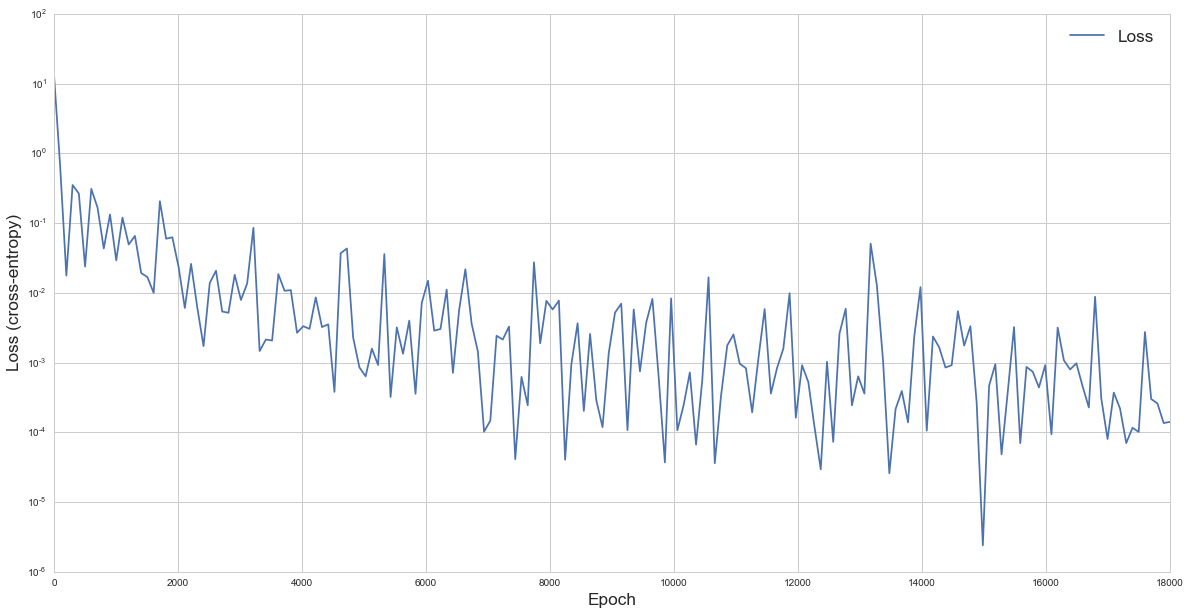

In [13]:
plt.figure(figsize=(20, 10))
plt.semilogy(np.linspace(0, len(losses) * 100, len(losses)), losses, label='Loss')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss (cross-entropy)', fontsize='xx-large')
plt.legend(fontsize='xx-large')

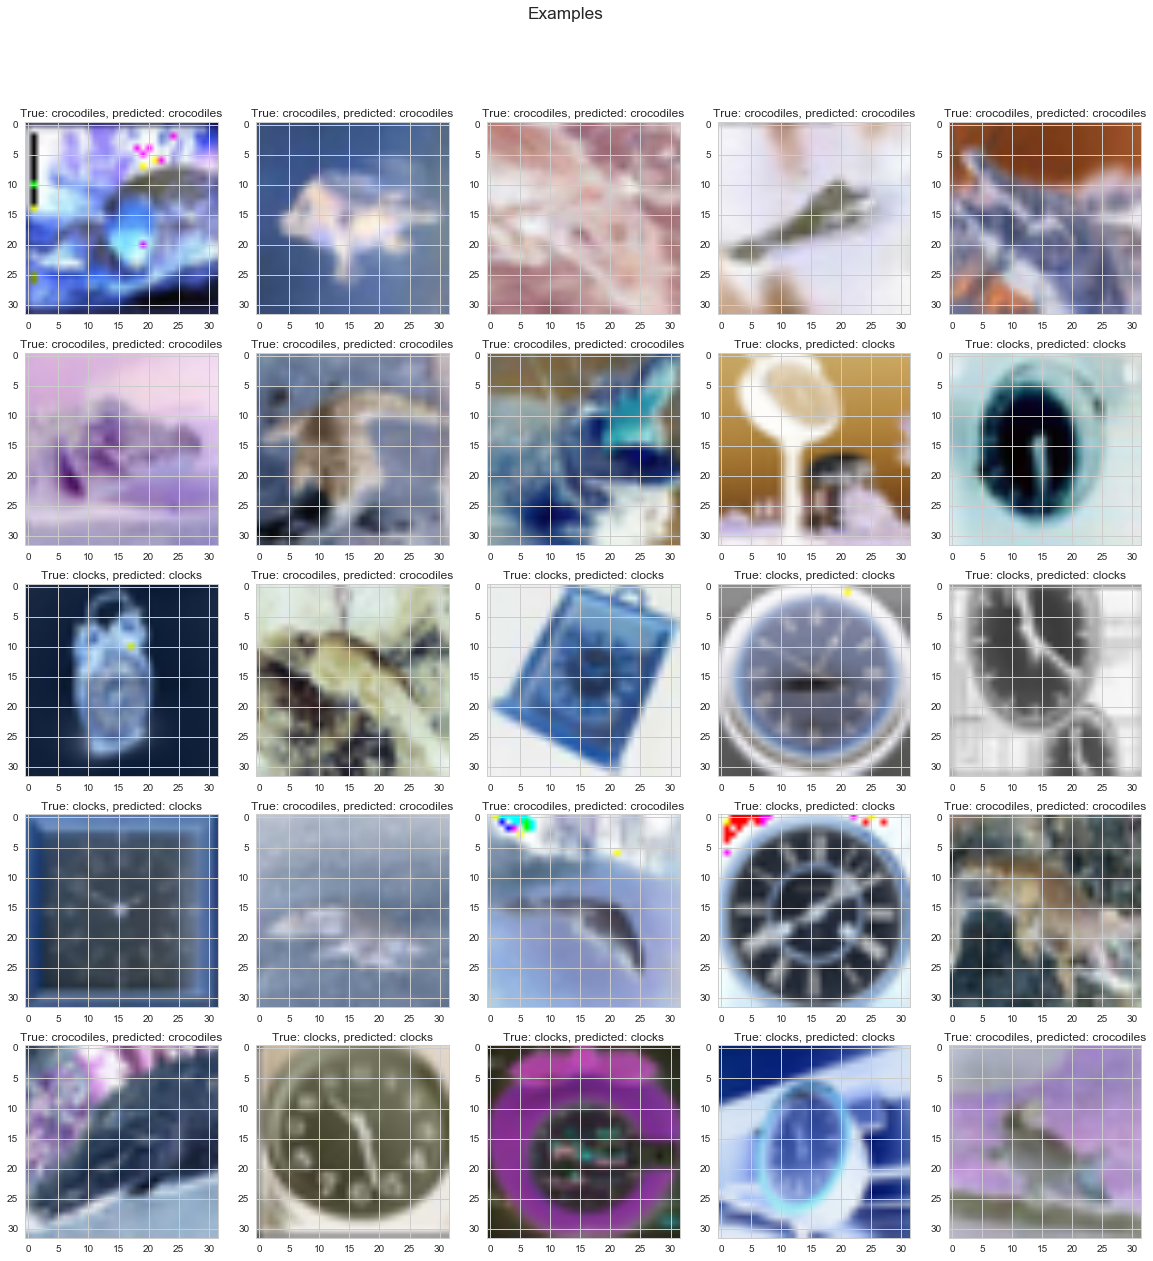

In [15]:
plt.figure(figsize=(20, 20))

view_idx = np.random.permutation(range(len(test_dataset)))[:25]
view_dataset = test_dataset[view_idx, :, :, :]
view_labels = np.array(y_test)[view_idx]
plt.suptitle('Examples', fontsize='xx-large')
for i in range(len(view_dataset)):
    plt.subplot(5, 5, 5 * (i / 5) + i % 5 + 1)
    plt.title('True: %s, predicted: %s' % (names[view_labels[i]], names[np.argmax(test_preds, axis=1)[view_idx[i]]]))
    plt.imshow(view_dataset[i] * pixel_depth + pixel_depth / 2)

In [ ]:
with tf.Session(graph=graph) as session:
    loader = tf.train.import_meta_graph('./model/model.meta')
    loader.restore(session, './model/model')
    
    ops = tf.get_collection('ops')
    test_prediction = ops[0]
    
    preds = test_prediction.eval()